# Jingyuan Zhou
# NLP Assignment 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import lil_matrix, coo_matrix
from scipy.stats import spearmanr
# from sklearn import metrics.pairwise.cosine_similarity
from scipy import spatial

%matplotlib inline

# 1. Required Tasks

## 1.1 Distributional Counting

In [2]:
V = list(pd.read_csv("vocab-wordsim.txt", header = None)[0])

f = open("vocab-25k.txt", 'r')
V_C = f.read().split('\n')
f.close()

f = open("wiki-1percent.txt", 'r')
wiki = f.read().split('\n')
f.close()

In [3]:
men = pd.read_table('men.txt')
simlex = pd.read_table('simlex-999.txt')

In [139]:
def get_word_index(Vocab):
    ret = dict()
    for index, word in enumerate(Vocab):
        ret[word] = index
    return ret

In [148]:
def get_C(w, V, V_C):
    V_set = get_word_index(V)
    V_C_set = get_word_index(V_C)
    
    C = lil_matrix((len(V), len(V_C)))
    for sent in wiki:
        sent = sent.split()
        sent.insert(0, '<s>')
        sent.append('</s>')
        for loc, word in enumerate(sent):
            try:
                i = V_set[word]
                for c in sent[max(loc-w, 0):loc+w+1]:
                    try:
                        j = V_C_set[c]
                        C[i, j] += 1
    #                     print(word, c)
                    except:
                        continue

            except:
                continue    
    return C

In [209]:
V_set = get_word_index(V)
V_C_set = get_word_index(V_C)

In [20]:
w = 3
C_3 = get_C(w, V_set, V_C_set)

In [211]:
def get_cosine(C, x, y, V_set = V_set):
    try:
        i = V_set[x]
        j = V_set[y]
        return 1 - spatial.distance.cosine(C.getrow(i).toarray(), C.getrow(j).toarray())

    except:
        return 0

In [212]:
def EVALWS(C, V_set, df):
    myscore = df.apply(lambda x: get_cosine(C, x[0], x[1]),1)
    return spearmanr(df.iloc[:, -1],myscore)[0]

In [23]:
men_c_3 = EVALWS(C_3, men)
simlex_c_3 = EVALWS(C_3, simlex)

/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/scipy-0.18.1-py2.7-linux-x86_64.egg/scipy/spatial/distance.py:326: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


In [230]:
print men_c_3
print simlex_c_3

0.225178836606
0.0943947630532


## 1.2 Computing PMIs

In [37]:
def pmi(p_xy, p_x, p_y):
    # i is the center word, and j is the word in the context window
    return max(np.log2(p_xy/(p_x*p_y)),0) #note: actually ppmi

In [177]:
def get_C_pmi(C, sym, V = V, V_C = V_C, index = None):
    C_ = C.tocoo()
    
    # make C a dataframe
    d = {'i': C_.row, 'j': C_.col, 'ij': zip(C_.row, C_.col), 'data': C_.data}
    C_df = pd.DataFrame(d)
    
    C_i = []
    for i in range(len(V)):
        C_i.append(sum(C_df[C_df['i'] == i]['data']))
  
    C_j = []
    for j in range(len(V_C)):
        C_j.append(sum(C_df[C_df['j'] == j]['data']))
    
    t = sum(C_df['data'])  
#     rows,cols = C_.nonzero()
#     tuples = zip(rows,cols)
    
    print 'Finished preliminary calculations'
    
    C_df['pmi'] = C_df.apply(lambda x: cal(x, t, C_df, C_i, C_j, sym),1)
    return coo_matrix((C_df['pmi'], (C_df['i'], C_df['j']))).tolil()

In [189]:
def cal(x, t, C_df, C_i, C_j, sym):
    #print x
    i = x['i']
    j = x['j']
#     if sym:
#         res = int(C_df[C_df['ij'] == (i, j)]['pmi'])
#         return res
    v = x['data']
    p_xy = v/t
    p_x = C_i[i]/t
    p_y = C_j[j]/t
    return pmi(p_xy, p_x, p_y)

In [169]:
C_pmi_3 = get_C_pmi(C_3, False)

Finished prelimenary calculations


In [172]:
men_cpmi_3 = EVALWS(C_pmi_3, men)
simlex_cpmi_3 = EVALWS(C_pmi_3, simlex)

In [232]:
print men_cpmi_3
print simlex_cpmi_3

0.531649006921
0.214886839911


So there's more correlation to human coding result when we use pmi instead of pure frequency-based word vectors.

## 1.3 Experimentation

In [175]:
# w=1
C_1 = get_C(11, V, V_C)
men_c_1 = EVALWS(C_1, men)                                                                                                                                  
simlex_c_1 = EVALWS(C_1, simlex)

In [176]:
C_pmi_1 = get_C_pmi(C_1, False)
men_cpmi_1 = EVALWS(C_pmi_1, men)
simlex_cpmi_1 = EVALWS(C_pmi_1, simlex)

Finished prelimenary calculations


In [178]:
# w=6
C_6 = get_C(6, V, V_C)
print 'Finished C'
men_c_6 = EVALWS(C_6, men)
simlex_c_6 = EVALWS(C_6, simlex)

Finished C


In [179]:
C_pmi_6 = get_C_pmi(C_6, False)
men_cpmi_6 = EVALWS(C_pmi_6, men)
simlex_cpmi_6 = EVALWS(C_pmi_6, simlex)

Finished preliminary calculations


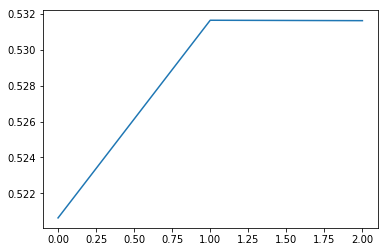

In [183]:
plt.plot([men_cpmi_1, men_cpmi_3, men_cpmi_6])

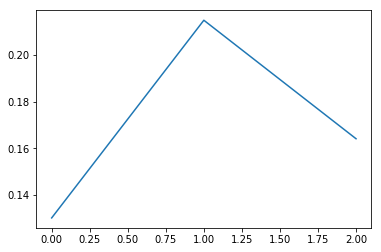

In [185]:
plt.plot([simlex_cpmi_1, simlex_cpmi_3, simlex_cpmi_6])

Here, we only compare results using pmi. We could observe that as window size increases, the correlation between our result and human encoding result generally increases as well.

Since Simlex-999 measures paraphrastic similarity: two words are “similar” if they have similar meanings and MEN measures relatedness, our result based on pmi correlates more with MEN.

## 1.4 Analysis

### 1.4.1 Warm-up: Printing nearest neighbors

In [192]:
M_1 = get_C(1, V_C, V_C)
M_pmi_1 = get_C_pmi(M_1, True, V = V_C)

M_6 = get_C(6, V_C, V_C)
M_pmi_6 = get_C_pmi(M_6, True, V = V_C)

In [213]:
q = 'monster'
def get_nnn(q):
    cos_similarity_1 = []
    cos_similarity_6 = []
    for word in V_C:
        if word == q:
            cos_1 = 1
            cos_6 = 1
        else:
            cos_1 = get_cosine(M_pmi_1, q, word, V_set = V_C_set)
            cos_6 = get_cosine(M_pmi_6, q, word, V_set = V_C_set)

        cos_similarity_1.append(cos_1)
        cos_similarity_6.append(cos_6)
    d = {'word': V_C, 'sim_1': cos_similarity_1, 'sim_6': cos_similarity_6}
    df = pd.DataFrame(d)
    return df

In [214]:
monster_df = get_nnn(q)

In [225]:
monster_df.sort_values(by = 'sim_1', ascending = False).head(16)

,sim_1,sim_6,word
4854,1.000000,1.000000,monster
12924,0.118009,0.107380,clown
21899,0.114411,0.061970,cock
23907,0.111315,0.060991,spaghetti
17747,0.109690,0.053334,commonplace
19840,0.109082,0.086882,ness
24736,0.105299,0.038148,brant
15071,0.102020,0.062498,slayer
17413,0.095218,0.092887,humanoid
17280,0.093721,0.055793,closet


In [226]:
monster_df.sort_values(by = 'sim_6', ascending = False).head(5)

,sim_1,sim_6,word
4854,1.000000,1.000000,monster
19217,0.053481,0.130149,godzilla
3159,0.057593,0.129211,evil
3248,0.076708,0.127128,giant
19,0.062949,0.126852,""""


### 1.4.2 Part-of-speech tag similarity in nearest neighbors

Do nearest neighbors tend to have the same part-of-speech tag as the query word, or do they differ? Does the pattern differ across different part-of-speech tags for the query word? How does window size affect this?

In [236]:
noun = ['apple', 'people', 'book']
verb = ['transported', 'graduated', 'become']
adj = ['pretty', 'magnificent', 'famous']
prep = ['in', 'between', 'for']
l = [noun, verb, adj, prep]

In [244]:
for words in l:
    for q in words:
        print(q)
        res = get_nnn(q)
        print 'TOP 10 when w = 1:'
        print list(res.sort_values(by = 'sim_1', ascending = False).head(10)['word'])
        print 'TOP 10 when w = 6:'
        print list(res.sort_values(by = 'sim_6', ascending = False).head(10)['word'])
        print '------------------------------------------------------------------\n'

apple
TOP 10 when w = 1:
['apple', 'macintosh', 'orchards', 'ipod', 'scribe', 'chili', 'iphone', 'cherry', 'os', 'dessert']
TOP 10 when w = 6:
['apple', 'macintosh', 'os', 'ios', 'microsoft', 'ipad', 'software', 'desktop', 'mac', 'iphone']
------------------------------------------------------------------

people
TOP 10 when w = 1:
['people', 'students', 'households', 'men', 'years', 'approximately', 'inhabitants', 'families', 'individuals', 'bc']
TOP 10 when w = 6:
['people', 'about', 'population', 'they', 'them', 'there', 'were', 'their', 'more', 'who']
------------------------------------------------------------------

book
TOP 10 when w = 1:
['book', 'books', 'novel', 'story', 'paperback', 'album', 'film', 'memoir', 'comic', 'edition']
TOP 10 when w = 6:
['book', 'published', 'books', "'s", 'written', 'wrote', 'author', 'novel', '"', 'story']
------------------------------------------------------------------

transported
TOP 10 when w = 1:
['transported', 'northwards', 'wolverines'

As we could observe in these examples, it depends on the part-of-speech of the word in concern.
1. The word is a noun:
when window size is small, 1 in our case, the nearest neighbors tend to be of the same part-of-speech as the word in question; however, when the window size is larger, the nearest neighbors tend to be an adjective. e.g. 'people', 'book'

2. The word is a verb:
The window size does not matter too much. The nearest neighbors are mostly nouns and verbs.

3. The word is an adjective:
In the case of 'pretty' and 'famous', when window size is small, the nearest neighbors are mostly adj and adv, and when window size is larger, the nearest neighbors are generally not adjectives; however, the nearest neighbors are basically all nouns for 'magnificent' regardless of window size.

4. The word is an preposition:
The situation is different among the words. 

To conclude, whether the nearest neighbors are of the same part-of-speech of the word in concern varies across part-of-speeches and the words themselves. Based on what we observed in this practices, there does not seem to be a universal systematic trend. This situation could be changed if we have more data and also a variety of data sources.


### 1.4.3 Words with multiple senses
Now try choosing words with multiple senses (e.g., bank, cell, apple, apples, axes, frame, light, well, etc.) as query words. What appears to be happening with these words? What happens when you compare the neighbors with different window sizes (w = 1 vs. w = 6)? Discuss your findings, showing examples of nearest neighbors for particular words to support your claims.

In [245]:
multi_words = 'bank, cell, apple, axes, frame, light, well'.split(', ')

In [246]:
for q in multi_words:
    print(q)
    res = get_nnn(q)
    print 'TOP 10 when w = 1:'
    print list(res.sort_values(by = 'sim_1', ascending = False).head(10)['word'])
    print 'TOP 10 when w = 6:'
    print list(res.sort_values(by = 'sim_6', ascending = False).head(10)['word'])
    print '------------------------------------------------------------------\n'

bank
TOP 10 when w = 1:
['bank', 'banks', 'insurance', 'banking', 'company', 'corporation', 'fargo', 'savings', 'lakeland', 'co-operative']
TOP 10 when w = 6:
['bank', 'banks', 'company', 'banking', 'river', 'corporation', 'investment', 'west', 'located', 'south']
------------------------------------------------------------------

cell
TOP 10 when w = 1:
['cell', 'cells', 'cellular', 'carcinoma', 'tissue', 'protein', 'lung', 'neuronal', 'renal', 'proteins']
TOP 10 when w = 6:
['cell', 'cells', 'protein', 'proteins', 'membrane', 'cellular', 'receptor', 'dna', 'signaling', 'molecules']
------------------------------------------------------------------

apple
TOP 10 when w = 1:
['apple', 'macintosh', 'orchards', 'ipod', 'scribe', 'chili', 'iphone', 'cherry', 'os', 'dessert']
TOP 10 when w = 6:
['apple', 'macintosh', 'os', 'ios', 'microsoft', 'ipad', 'software', 'desktop', 'mac', 'iphone']
------------------------------------------------------------------

axes
TOP 10 when w = 1:
['axes', 

It seems to vary across words:

Somewhat Clear Differentiation of meaning:
- For 'apple', when window size is small, all nearest neighbors are related to the fruit apple; however, when the window size is larger, the nearest neighbors are related to Apple Inc.

- For 'bank', when window size is small, all nearest neighbors are related to the financial institution; however, when the window size is larger, the nearest neighbors are a mix of the financial instituion and bank as in 'bank of a river'.

Both window sizes only clearly pick up one meaning:
e.g. 'cell' and 'axes'

Both window sizes vaguely pick up two meanings:
e.g. 'ligtht' and 'well'

Again, as we've discussed in the part-of-speech case, I think these observations could only specific to this wikipedia dataset. We might get different results if we use a combination of different resources or a larger dataset. 